In [3]:
import torch
from vae import VariationalAutoencoder
PATH = "model.pt"

model = VariationalAutoencoder(14, 7, 3)
model.load_state_dict(torch.load(PATH))
model.eval()



VariationalAutoencoder(
  (encoder): Encoder(
    (fc_mu): Sequential(
      (0): Linear(in_features=14, out_features=12, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=12, out_features=10, bias=True)
      (5): ReLU()
      (6): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=10, out_features=7, bias=True)
    )
    (fc_logvar): Sequential(
      (0): Linear(in_features=14, out_features=12, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=12, out_features=10, bias=True)
      (5): ReLU()
      (6): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Dropout(p=0.1, 

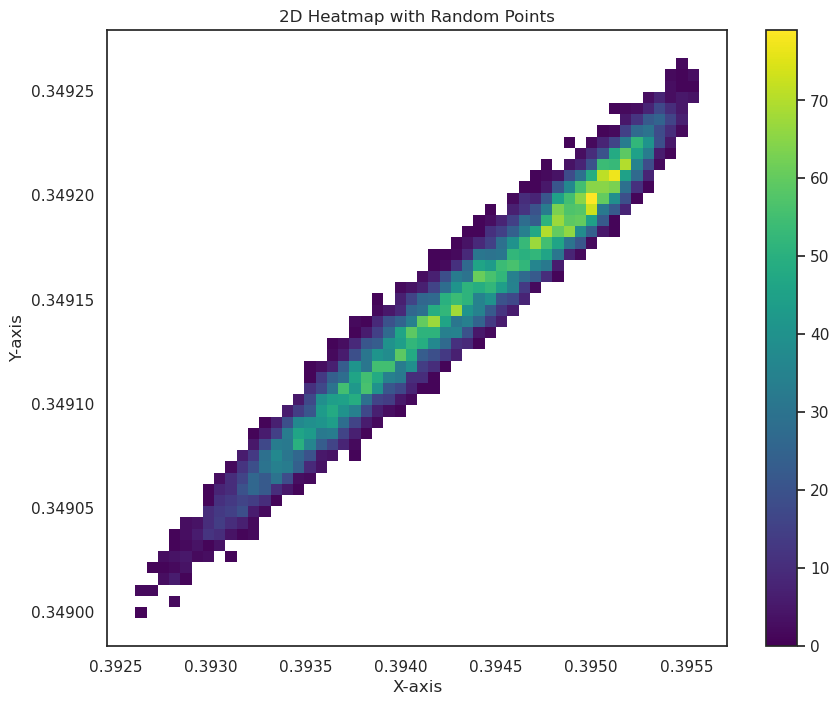

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

nSamples = 10000

noise = torch.tensor(np.random.uniform(
    low=0, high=1, size=(nSamples, 7)), dtype=torch.float32)
team = torch.tensor([0]*nSamples, dtype=torch.float32)
predicted = model.decoder(noise, team)

x = predicted[:, 0].detach().numpy()
y = predicted[:, 1].detach().numpy()

x = x.T
y = y.T

sns.set(style="white")
plt.figure(figsize=(10, 8))

heatmap = sns.histplot(x=x.flatten(), y=y.flatten(),
                       bins=(50, 50), cmap="viridis", cbar=True)

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("2D Heatmap with Random Points")

plt.show()

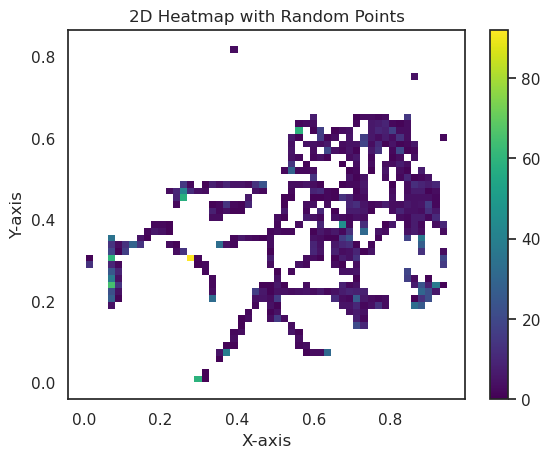

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("processed.csv")
min_value_x = df.filter(like='x_pos_').min().min()
max_value_x = df.filter(like='x_pos_').max().max()

min_value_y = df.filter(like='y_pos_').min().min()
max_value_y = df.filter(like='y_pos_').max().max()

for column in df.columns:
    mask = df[column].isnull()
    if column.startswith('x_pos_'):
        df.loc[mask, column] = np.random.uniform(
            min_value_x, max_value_x, size=np.sum(mask))
        df[column] = (df[column] - min_value_x)/max_value_x
    elif column.startswith('y_pos_'):
        df.loc[mask, column] = np.random.uniform(
            min_value_y, max_value_y, size=np.sum(mask))
        df[column] = (df[column] - min_value_y)/max_value_y
i = 1
x = df[f"x_pos_{i}"].to_numpy()
y = df[f"y_pos_{i}"].to_numpy()

heatmap = sns.histplot(x=x, y=y,
                       bins=(50, 50), cmap="viridis", cbar=True)

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("2D Heatmap with Random Points")

plt.show()